In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Define Directories for train, test & Validation Set
train_path = r'C:\Users\Utilizador\Desktop\Projectos Data Sciene\Ironhack\Final_Project_3\chest_xray\train'
test_path = r'C:\Users\Utilizador\Desktop\Projectos Data Sciene\Ironhack\Final_Project_3\chest_xray\test'
valid_path = r'C:\Users\Utilizador\Desktop\Projectos Data Sciene\Ironhack\Final_Project_3\chest_xray\val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500
img_height = 200
img_width = 200
#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. A lower dimension size with greater batch size is one of the options to try.

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
# We'll normalize the images of train and test by dividing them for 255
# In the train dataset we'll apply random operations in order to generate more diverse images, so the model can learn better.
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [31]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4342 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [32]:
Y_batch[0]

0.0

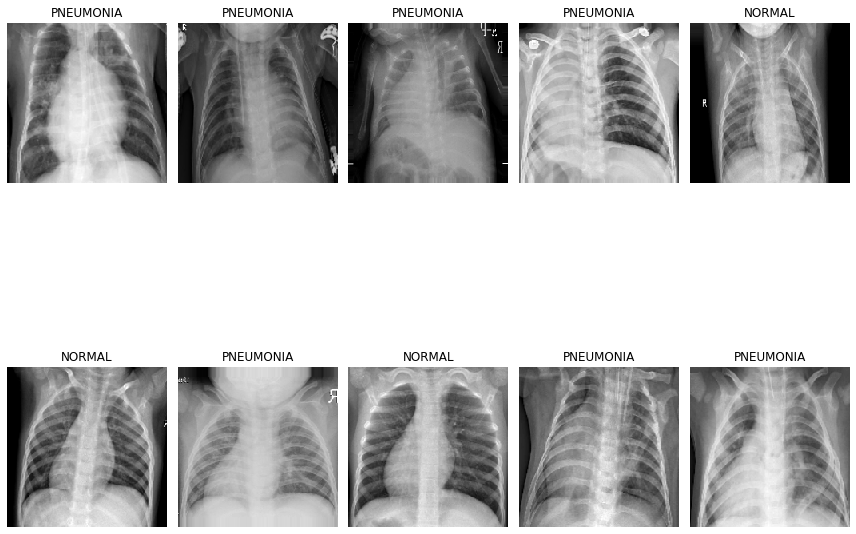

In [33]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [35]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [36]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [40]:
# Visualize CNN model
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [42]:
# Define a callback list to stop the learning model if some conditions are achieved

# Stop training when a monitored metric has stopped improving
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
# Reduce learning rate when a metric has stopped improving
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [48]:
# Assign class weights

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',classes= np.unique(train.classes),y= train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.6189410887397464, 1: 0.7234255248250583}


In [51]:
unique_elements, counts_elements = np.unique(train.classes, return_counts=True)

In [52]:
unique_elements

array([0, 1])

In [53]:
counts_elements

array([1341, 3001], dtype=int64)

In [57]:
print('class 0 balanced: ' ,cw[0]*counts_elements[0])
print('class 1 balanced: ' ,cw[1]*counts_elements[1])

class 0 balanced:  2171.0
class 1 balanced:  2171.0


In [58]:
cnn.fit(train,epochs=6, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/6
272/272 [==============================] - 223s 817ms/step - loss: 0.4753 - accuracy: 0.7220 - val_loss: 0.6063 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/6
272/272 [==============================] - 246s 902ms/step - loss: 0.2480 - accuracy: 0.9037 - val_loss: 0.5382 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/6
272/272 [==============================] - 244s 895ms/step - loss: 0.2338 - accuracy: 0.9056 - val_loss: 1.0308 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/6
272/272 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9136
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
272/272 [==============================] - 255s 938ms/step - loss: 0.2253 - accuracy: 0.9136 - val_loss: 1.0250 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/6
272/272 [==============================] - 255s 937ms/step - loss: 0.1780 - accuracy: 0.9298 - val_loss: 0.3494 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 6/6
272/272 [==========================

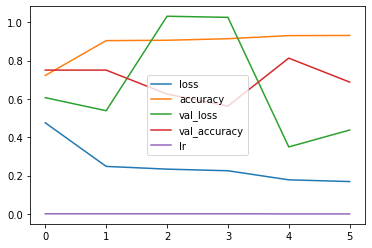

In [59]:
pd.DataFrame(cnn.history.history).plot()

In [60]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 11s 270ms/step - loss: 0.2563 - accuracy: 0.8990
The testing accuracy is : 89.90384340286255 %


In [61]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 10s 253ms/step


In [62]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

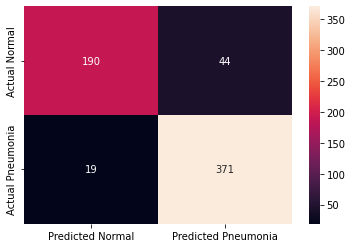

In [71]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [64]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.91      0.81      0.86       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



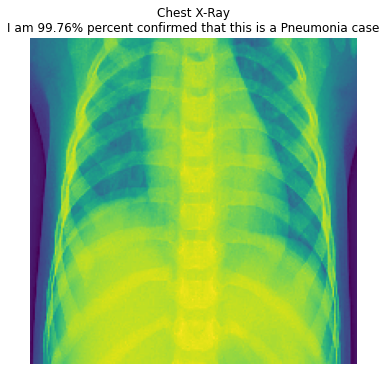

In [85]:
# Testing with a X-Ray image
path = 'person1_bacteria_1.jpeg'
from tensorflow.keras.preprocessing import image
img = image.load_img(path, target_size=(200, 200),color_mode='grayscale')
# Preprocessing the image
pp_img = image.img_to_array(img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)
#predict
img_preds= cnn.predict(pp_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if img_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(img_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-img_preds[0][0]))
plt.title("Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()

In [86]:
# save model
cnn.save("xray_model.h5")

In [89]:
from keras.models import load_model
model=load_model(r'C:\Users\Utilizador\Desktop\Projectos Data Sciene\Ironhack\Final_Project_3\flask_apps\xray_model.h5')

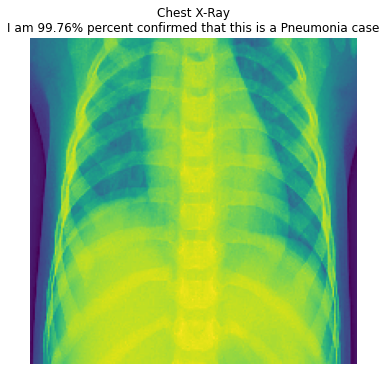

In [90]:
# Testing with a X-Ray image
path = 'person1_bacteria_1.jpeg'
from tensorflow.keras.preprocessing import image
img = image.load_img(path, target_size=(200, 200),color_mode='grayscale')
# Preprocessing the image
pp_img = image.img_to_array(img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)
#predict
img_preds= model.predict(pp_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if img_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(img_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-img_preds[0][0]))
plt.title("Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_img))
plt.show()